In [1]:
!pip install torch
!pip install pandas
!pip install nltk
!pip install emoji
!pip install tensorflow

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
import pandas as pd
import re
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
import matplotlib.pyplot as plt
import nltk

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
# Load data
df = pd.read_csv('/thelinkof/cleaned_movie_data_comment.csv')

# Clean text data
def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = re.sub(r'<.*?>', '', text)
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower().strip()
    return text

df['cleaned_comment'] = df['comment_text'].apply(clean_text)

# Tokenize using RNN-based tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_comment'])

sequences = tokenizer.texts_to_sequences(df['cleaned_comment'])
padded_sequences = pad_sequences(sequences, maxlen=512)

# One-hot encode labels
labels = df['comment_rating'].apply(lambda x: 2 if x >= 7 else (1 if x >= 4 else 0))
labels = to_categorical(labels)

# Split data
train_sequences, test_sequences, train_labels, test_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Define LSTM model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=512))
model.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [5]:
# Train model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model.fit(train_sequences, train_labels, epochs=3, batch_size=16, validation_data=(test_sequences, test_labels), callbacks=[early_stopping])

# Evaluate model
loss, accuracy = model.evaluate(test_sequences, test_labels)
print(f"Results: Loss={loss:.3f}, Accuracy={accuracy:.3f}")

# Evaluate function
def evaluate(model, test_sequences, test_labels):
    predictions = model.predict(test_sequences)
    predictions = predictions.argmax(axis=1)
    true_labels = test_labels.argmax(axis=1)
    return predictions, true_labels

# Evaluate the model
predictions, true_labels = evaluate(model, test_sequences, test_labels)

Epoch 1/3
1182/1182 [==============================] - 2140s 2s/step - loss: 0.3642 - accuracy: 0.8897 - val_loss: 0.3573 - val_accuracy: 0.8807
Epoch 2/3
1182/1182 [==============================] - 2097s 2s/step - loss: 0.2710 - accuracy: 0.9057 - val_loss: 0.3922 - val_accuracy: 0.8777
Epoch 3/3
148/148 [==============================] - 24s 162ms/step - loss: 0.4237 - accuracy: 0.8637
Results: Loss=0.424, Accuracy=0.864
148/148 [==============================] - 24s 158ms/step


In [6]:
# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
precision = precision_score(true_labels, predictions, average='weighted')
roc_auc = roc_auc_score(pd.get_dummies(true_labels), pd.get_dummies(predictions), multi_class='ovr')


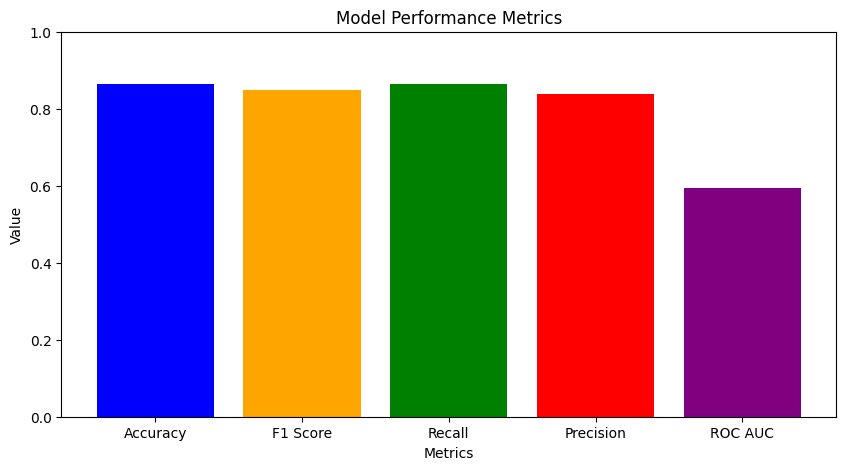

In [7]:
# Plot metrics
metrics = {'Accuracy': accuracy, 'F1 Score': f1, 'Recall': recall, 'Precision': precision, 'ROC AUC': roc_auc}
metrics_names = list(metrics.keys())
metrics_values = list(metrics.values())
plt.figure(figsize=(10, 5))
plt.bar(metrics_names, metrics_values, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Model Performance Metrics')
plt.ylim(0, 1)
plt.show()

In [8]:
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

Accuracy: 0.8637
F1 Score: 0.8488
Recall: 0.8637
Precision: 0.8381
ROC AUC: 0.5953
